# AlexNet
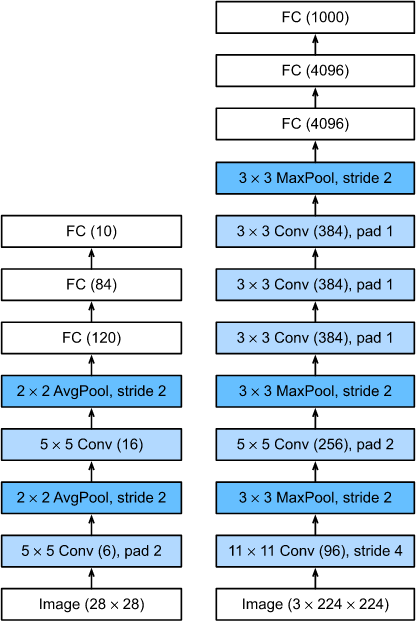

In [1]:
import torch
import torch.nn as nn
from d2l import torch as d2l

In [2]:
net = nn.Sequential(nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                    nn.Conv2d(96, 256, kernel_size=5, padding=2),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                    nn.Conv2d(256, 384, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(384, 384, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(384, 256, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                    nn.Flatten(),
                    nn.Linear(6400, 4096),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(4096, 4096),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(4096, 10)
                    )

In [3]:
X = torch.randn((1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'shape: ', X.shape)

Conv2d shape:  torch.Size([1, 96, 54, 54])
ReLU shape:  torch.Size([1, 96, 54, 54])
MaxPool2d shape:  torch.Size([1, 96, 26, 26])
Conv2d shape:  torch.Size([1, 256, 26, 26])
ReLU shape:  torch.Size([1, 256, 26, 26])
MaxPool2d shape:  torch.Size([1, 256, 12, 12])
Conv2d shape:  torch.Size([1, 384, 12, 12])
ReLU shape:  torch.Size([1, 384, 12, 12])
Conv2d shape:  torch.Size([1, 384, 12, 12])
ReLU shape:  torch.Size([1, 384, 12, 12])
Conv2d shape:  torch.Size([1, 256, 12, 12])
ReLU shape:  torch.Size([1, 256, 12, 12])
MaxPool2d shape:  torch.Size([1, 256, 5, 5])
Flatten shape:  torch.Size([1, 6400])
Linear shape:  torch.Size([1, 4096])
ReLU shape:  torch.Size([1, 4096])
Dropout shape:  torch.Size([1, 4096])
Linear shape:  torch.Size([1, 4096])
ReLU shape:  torch.Size([1, 4096])
Dropout shape:  torch.Size([1, 4096])
Linear shape:  torch.Size([1, 10])


In [4]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

KeyboardInterrupt: 

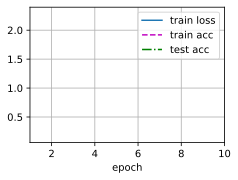

In [5]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cpu')

# VGG
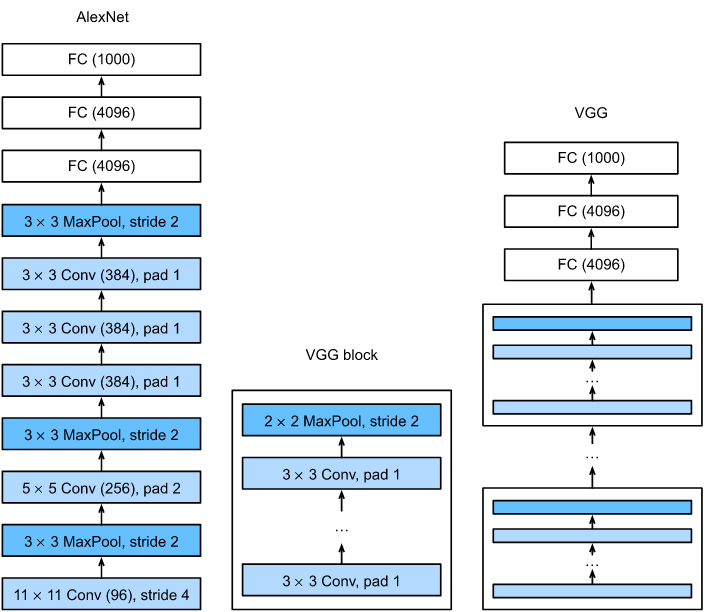

In [2]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (5, 512))

In [4]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(*conv_blks, nn.Flatten(), 
                        nn.Linear(out_channels*7*7, 4096), nn.ReLU(),
                        nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(),
                        nn.Dropout(0.5), nn.Linear(4096, 10))

In [6]:
net = vgg(conv_arch)
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, X.shape)

Sequential torch.Size([1, 64, 112, 112])
Sequential torch.Size([1, 128, 56, 56])
Sequential torch.Size([1, 256, 28, 28])
Sequential torch.Size([1, 512, 14, 14])
Sequential torch.Size([1, 512, 7, 7])
Flatten torch.Size([1, 25088])
Linear torch.Size([1, 4096])
ReLU torch.Size([1, 4096])
Dropout torch.Size([1, 4096])
Linear torch.Size([1, 4096])
ReLU torch.Size([1, 4096])
Dropout torch.Size([1, 4096])
Linear torch.Size([1, 10])


training on cpu


KeyboardInterrupt: 

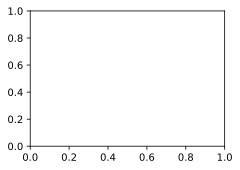

In [7]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# NiN
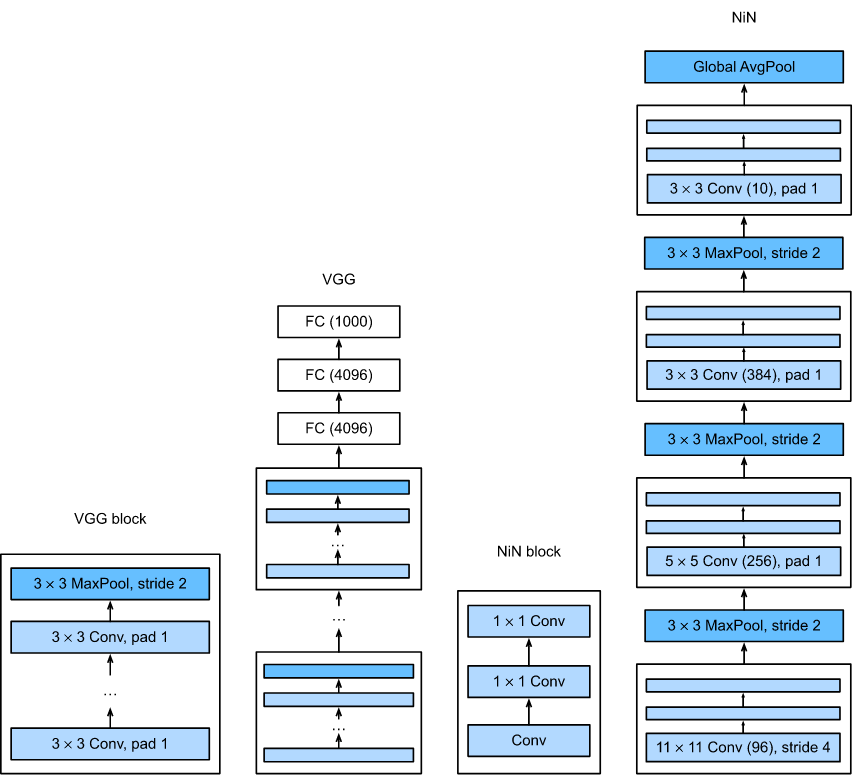

In [2]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), 
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
        )

In [4]:
net = nn.Sequential(
        nin_block(1, 96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2d(3, stride=2),
        nin_block(96, 256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2d(3, stride=2),
        nin_block(256, 384, kernel_size=3, strides=1, padding=1),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout(0.5),
        # 10个标签
        nin_block(384, 10, kernel_size=3, strides=1, padding=1),
        nn.AdaptiveAvgPool2d((1, 1)), # (1, 1)表示输出的大小为1*1
        nn.Flatten())

In [5]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'shape:', X.shape)

Sequential shape: torch.Size([1, 96, 54, 54])
MaxPool2d shape: torch.Size([1, 96, 26, 26])
Sequential shape: torch.Size([1, 256, 26, 26])
MaxPool2d shape: torch.Size([1, 256, 12, 12])
Sequential shape: torch.Size([1, 384, 12, 12])
MaxPool2d shape: torch.Size([1, 384, 5, 5])
Dropout shape: torch.Size([1, 384, 5, 5])
Sequential shape: torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d shape: torch.Size([1, 10, 1, 1])
Flatten shape: torch.Size([1, 10])


# GoogLeNet
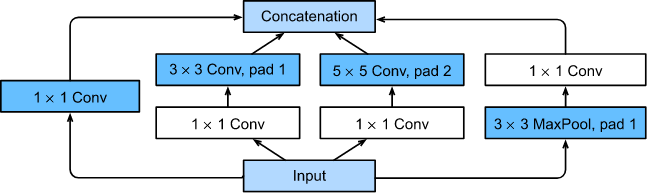

In [10]:
import torch.nn.functional as F
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，1*1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1*1接3*3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1*1接5*5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3*3最大池化接1*1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        
        # 注意在第二个通道拼接
        return torch.cat((p1, p2, p3, p4), dim=1)

In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [4]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [5]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   # 64+128+32+32=256
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   # 128+192+96+64=480
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [11]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "shape: ", X.shape)

Sequential shape:  torch.Size([1, 64, 24, 24])
Sequential shape:  torch.Size([1, 192, 12, 12])
Sequential shape:  torch.Size([1, 480, 6, 6])
Sequential shape:  torch.Size([1, 832, 3, 3])
Sequential shape:  torch.Size([1, 1024])
Linear shape:  torch.Size([1, 10])


# Batch-Norm

In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled(): # 说明是预测模式
        X_hat = (X - moving_mean) / torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 全连接层
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 二维卷积，计算axis=1
            # 保持形状一直，只计算axis=1
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1 - momentum) * mean
        moving_var = momentum * moving_var + (1 - momentum) * var
    Y = gamma * x_hat + beta
    
    return Y, moving_mean.data, moving_var.data

In [3]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, 
            self.moving_var, eps=1e-5, momentum=0.9)
        
        return Y

In [4]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), 
                    BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), 
                    BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), 
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), 
                    nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), 
                    nn.Sigmoid(),
                    nn.Linear(120, 84), 
                    BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

In [5]:
# 简明实现
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), 
                    nn.BatchNorm2d(6),
                    nn.Sigmoid(), 
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), 
                    nn.BatchNorm2d(16),
                    nn.Sigmoid(), 
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), 
                    nn.Linear(256, 120), 
                    nn.BatchNorm1d(120),
                    nn.Sigmoid(), 
                    nn.Linear(120, 84), 
                    nn.BatchNorm1d(84),
                    nn.Sigmoid(), 
                    nn.Linear(84, 10))

# ResNet
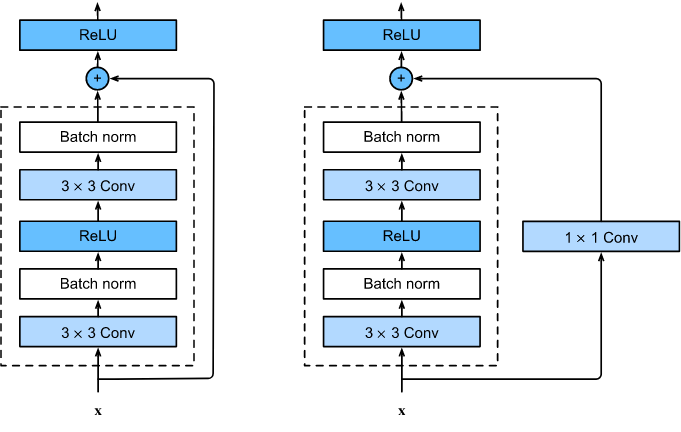

In [12]:
import torch.nn.functional as F
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, 
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, 
                               kernel_size=3, padding=1, 
                               stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        
        Y += X  # 注意残差是在relu前进行加和
        
        return F.relu(Y)
        

In [13]:
blk = Residual(3, 3) # 输入和输出都是3，不用1*1卷积
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [14]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [15]:
# ResNet模型
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), 
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [16]:
def resnet_block(input_channels, num_channels, num_residuals, 
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            # 第一个block输入和输出形状相同
            blk.append(Residual(num_channels, num_channels))
    return blk

In [17]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [18]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                   nn.Flatten(), nn.Linear(512, 10))

In [19]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "shape: ", X.shape)

Sequential shape:  torch.Size([1, 64, 56, 56])
Sequential shape:  torch.Size([1, 64, 56, 56])
Sequential shape:  torch.Size([1, 128, 28, 28])
Sequential shape:  torch.Size([1, 256, 14, 14])
Sequential shape:  torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d shape:  torch.Size([1, 512, 1, 1])
Flatten shape:  torch.Size([1, 512])
Linear shape:  torch.Size([1, 10])


# DenseNet
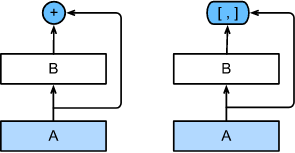

In [2]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(nn.BatchNorm2d(input_channels),
                         nn.ReLU(),
                         nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(
                conv_block(num_channels*i+input_channels, num_channels))
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)  # 拼接后继续训练
        
        return X

In [4]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape  # 10*2+3=23

torch.Size([4, 23, 8, 8])

In [5]:
# 引入过渡层来防止过拟合
def transition_block(input_channels, num_channels):
    return nn.Sequential(
            nn.BatchNorm2d(input_channels),
            nn.ReLU(),
            nn.Conv2d(input_channels, num_channels, kernel_size=1),
            nn.AvgPool2d(kernel_size=2, stride=2))

In [6]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [8]:
# 模型
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [10]:
num_channels, growth_rate = 64, 32   # 每次多加32个通道
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels//2))
        num_channels = num_channels // 2

In [11]:
net = nn.Sequential(b1, *blks, nn.BatchNorm2d(num_channels),
                    nn.ReLU(), 
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(),
                    nn.Linear(num_channels, 10))